In [321]:
import pandas as pd
import numpy as np

<h1> ML 10014 ชัชชาย จันทร์เพ็ชร์ </h1>

In [322]:
df = pd.read_csv("../../Datasets/Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [323]:
df.drop_duplicates().shape, df.shape

((7043, 21), (7043, 21))

# Change dataset Info 

In [324]:
df.SeniorCitizen = df.SeniorCitizen.astype("object")

In [325]:
df.TotalCharges.replace(" ",np.nan,inplace=True)
df.TotalCharges = df.TotalCharges.astype("float")

In [326]:
df.drop_duplicates().shape, df.shape

((7043, 21), (7043, 21))

In [327]:
X = df.drop(['customerID','Churn'],axis=1)
y = df.Churn

# Train Test split

In [328]:
from sklearn.model_selection import train_test_split

In [329]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

# Create Col for make Columns

In [330]:
numericCol = X_train.select_dtypes(include=["float","int"]).columns
nominalCol = X_train.select_dtypes(include=["object"]).columns

# Make Columns For Model

In [331]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

In [332]:
numericPipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('std', StandardScaler())
    ]
)

In [333]:
transformer = make_column_transformer(
    (numericPipeline , numericCol),
    (OneHotEncoder(), nominalCol),
    remainder = "passthrough"
)

In [334]:
X_train_scaler_transform = transformer.fit_transform(X_train)
X_test_scaler_transform = transformer.transform(X_test)

# Set Model

In [335]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [336]:
def Result(grid_list,X_train,Y_train,X_test,Y_test):
    model_name = []
    model_grid_bestpara = []
    model_grid_score_train = []
    model_recall_train =[]
    model_precision_train = []
    model_grid_score_test = []
    model_recall_test =[]
    model_precision_test = []
    model_grid = []
    for name, model in grid_list:
        model_name.append(name)
        model_grid.append(model)
        model_grid_bestpara.append(model.best_params_)
        model_grid_score_train.append(accuracy_score(y_train,model.predict(X_train)))
        model_recall_train.append(recall_score(y_train,model.predict(X_train),pos_label="Yes"))
        model_precision_train.append(precision_score(y_train,model.predict(X_train),pos_label="Yes"))
        model_grid_score_test.append(accuracy_score(y_test,model.predict(X_test)))
        model_recall_test.append(recall_score(y_test,model.predict(X_test),pos_label="Yes"))
        model_precision_test.append(precision_score(y_test,model.predict(X_test),pos_label="Yes"))
    d = {
        'model_name':model_name,
        "model_grid":model_grid,
        "model_best_parameter":model_grid_bestpara,
        "accuracy_train":model_grid_score_train,
        "recall_train":model_recall_train,
        "precision_train":model_precision_train,
        "accuracy_test":model_grid_score_test,
        "recall_test":model_recall_test,
        "precision_test":model_precision_test
    }
    df = pd.DataFrame(data=d)
  
    return df



In [337]:
from sklearn.model_selection import RandomizedSearchCV

In [338]:
def TrainModelCV(modelcv,cv,X_train,Y_train):
    modellocal = []
    for name,param, model in modelcv:
        gsv = RandomizedSearchCV(
        model,
        param,
        verbose = 1,
        cv=cv,
        n_jobs=-1
        )
        gsv.fit(X_train,Y_train)
        modellocal.append((name,gsv))
    return modellocal


In [339]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto','sqrt','log']
criterion = ['gini','entropy']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [340]:
leaf_size = list(range(1,50))
n_neighbors = list(range(1,30))
p=[1,2]
weights = ['uniform','distance']
algorithm = ['auto','ball_tree','kd_tree','brute']

In [341]:
RC_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion' : criterion,
               'random_state':[42]
               
            }
KNN_grid = {'leaf_size': leaf_size,
              'n_neighbors': n_neighbors,
              'p': p,
              'weights':weights,
              'algorithm':algorithm,
              }
DC_grid = { 'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'criterion' : criterion,
               'random_state':[42]
               }
svc = {'C':[0.05,0.1,0.2,0.3,0.25,0.4,0.5,0.6,0.7,0.8,0.9,1],
         'gamma':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],
         'kernel':['rbf','linear'],
         'random_state':[42]
        }
logistic_grid = {
    'penalty' : ['l1', 'l2'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['liblinear'],
    'random_state':[42]
}
BNB = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0],
         }

In [342]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDClassifier

# Train model and Result scale data

In [343]:
models = []
models.append(('RandomForest',RC_grid, RandomForestClassifier()))
models.append(('KNN',KNN_grid,KNeighborsClassifier()))
models.append(('DecisionTree',DC_grid,DecisionTreeClassifier()))
models.append(('SVC_scale', svc,SVC() ))
models.append(('BernoulliNB',BNB,BernoulliNB()))
models.append(('LogisticRegression',logistic_grid,LogisticRegression()))

In [344]:
grid_list =TrainModelCV(models,10,X_train_scaler_transform,y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


c:\Users\EMMIE\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.77315704 0.79871541        nan 0.79694141        nan 0.79303566
        nan        nan 0.79924763 0.77262355]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits


c:\Users\EMMIE\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.75167857 0.75062041 0.74547069        nan 0.75257171
        nan        nan 0.75167857 0.76535278]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


c:\Users\EMMIE\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 10 folds for each of 5 candidates, totalling 50 fits
Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [345]:
result = Result(grid_list,X_train_scaler_transform,y_train,X_test_scaler_transform,y_test)
result

,model_name,model_grid,model_best_parameter,accuracy_train,recall_train,precision_train,accuracy_test,recall_test,precision_test
0,RandomForest,"RandomizedSearchCV(cv=10, estimator=RandomFore...","{'random_state': 42, 'n_estimators': 1400, 'mi...",0.865282,0.628342,0.822397,0.812633,0.530831,0.689895
1,KNN,"RandomizedSearchCV(cv=10, estimator=KNeighbors...","{'weights': 'uniform', 'p': 2, 'n_neighbors': ...",0.806709,0.562834,0.659358,0.812633,0.581769,0.667692
2,DecisionTree,"RandomizedSearchCV(cv=10, estimator=DecisionTr...","{'random_state': 42, 'min_samples_split': 10, ...",0.846113,0.604947,0.766300,0.782825,0.455764,0.622711
3,SVC_scale,"RandomizedSearchCV(cv=10, estimator=SVC(), n_j...","{'random_state': 42, 'kernel': 'linear', 'gamm...",0.797835,0.530080,0.645240,0.821859,0.595174,0.689441
4,BernoulliNB,"RandomizedSearchCV(cv=10, estimator=BernoulliN...",{'alpha': 0.01},0.722755,0.801471,0.486607,0.729595,0.831099,0.493631
5,LogisticRegression,"RandomizedSearchCV(cv=10, estimator=LogisticRe...","{'solver': 'liblinear', 'random_state': 42, 'p...",0.803337,0.540107,0.657980,0.821150,0.600536,0.685015


# Ensammble

## Voting

In [346]:
from sklearn.ensemble import VotingClassifier

In [347]:
voting = VotingClassifier(estimators=[
   ('RandomForest', RandomForestClassifier(n_estimators=1200,min_samples_split=2,min_samples_leaf=4,max_features='auto',max_depth=30,criterion='gini',bootstrap=False,random_state=42)),
   ('KNN',KNeighborsClassifier(weights='uniform',p=2,n_neighbors=25,leaf_size=10,algorithm='brute')),
   ('DecisionTree',DecisionTreeClassifier(min_samples_leaf=2,min_impurity_split=2,max_features='auto',max_depth=10,criterion='gini',random_state=42)),
   ('SVC_scale',SVC(kernel='linear',gamma=0.6,C=0.5,random_state=42) ),
   ('BernoulliNB',BernoulliNB(alpha=0.01)),
   ('LogisticRegression',LogisticRegression(solver='liblinear',penalty='l1',C=0.615848211066026,random_state=42))])

In [348]:
vote_param ={
    'voting':['hard','soft'],
    'n_jobs':[-1]

}

In [349]:
grid_vote =TrainModelCV([('Voting',vote_param,voting)],10,X_train_scaler_transform,y_train)

c:\Users\EMMIE\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 10 folds for each of 2 candidates, totalling 20 fits


c:\Users\EMMIE\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.79924889        nan]
  warnings.warn(


In [350]:
vote_result= Result(grid_vote,X_train_scaler_transform,y_train,X_test_scaler_transform,y_test)

In [351]:
result = result.append(vote_result,ignore_index=True)
result

,model_name,model_grid,model_best_parameter,accuracy_train,recall_train,precision_train,accuracy_test,recall_test,precision_test
0,RandomForest,"RandomizedSearchCV(cv=10, estimator=RandomFore...","{'random_state': 42, 'n_estimators': 1400, 'mi...",0.865282,0.628342,0.822397,0.812633,0.530831,0.689895
1,KNN,"RandomizedSearchCV(cv=10, estimator=KNeighbors...","{'weights': 'uniform', 'p': 2, 'n_neighbors': ...",0.806709,0.562834,0.659358,0.812633,0.581769,0.667692
2,DecisionTree,"RandomizedSearchCV(cv=10, estimator=DecisionTr...","{'random_state': 42, 'min_samples_split': 10, ...",0.846113,0.604947,0.766300,0.782825,0.455764,0.622711
3,SVC_scale,"RandomizedSearchCV(cv=10, estimator=SVC(), n_j...","{'random_state': 42, 'kernel': 'linear', 'gamm...",0.797835,0.530080,0.645240,0.821859,0.595174,0.689441
4,BernoulliNB,"RandomizedSearchCV(cv=10, estimator=BernoulliN...",{'alpha': 0.01},0.722755,0.801471,0.486607,0.729595,0.831099,0.493631
5,LogisticRegression,"RandomizedSearchCV(cv=10, estimator=LogisticRe...","{'solver': 'liblinear', 'random_state': 42, 'p...",0.803337,0.540107,0.657980,0.821150,0.600536,0.685015
6,Voting,"RandomizedSearchCV(cv=10,\n ...","{'voting': 'hard', 'n_jobs': -1}",0.820909,0.540107,0.715678,0.819730,0.538874,0.710247


# Bagging

In [352]:
from sklearn.ensemble import BaggingClassifier

In [353]:
bagKNN = BaggingClassifier(base_estimator=KNeighborsClassifier(weights='uniform',p=2,n_neighbors=25,leaf_size=10,algorithm='brute'))
bagDc = BaggingClassifier(base_estimator=DecisionTreeClassifier(min_samples_leaf=2,min_impurity_split=2,max_features='auto',max_depth=10,criterion='gini',random_state=42))
bagNB = BaggingClassifier(base_estimator=BernoulliNB(alpha=0.01))



In [354]:
bag_para ={
    'n_estimators':[100],
    'bootstrap':[True,False],
    'bootstrap_features':[True,False],
    'oob_score':[True,False],
    'warm_start':[True,False],
    'n_jobs':[-1],
    'random_state':[42]

}

In [355]:
bagging_model = []
bagging_model.append(('BaggingKNN',bag_para,bagKNN))
bagging_model.append(('BaggingDecision',bag_para,bagDc))
bagging_model.append(('BaggingBernoulliNB',bag_para,bagNB))

In [356]:
grid_bagging =TrainModelCV(bagging_model,10,X_train_scaler_transform,y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


c:\Users\EMMIE\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.79285962 0.78717704        nan        nan
 0.78664639 0.79339374        nan 0.78664639]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


c:\Users\EMMIE\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [      nan       nan 0.7344696 0.7344696       nan 0.7344696       nan
       nan 0.7344696 0.7344696]
  warnings.warn(


Fitting 10 folds for each of 10 candidates, totalling 100 fits


c:\Users\EMMIE\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.72275613 0.72382091        nan        nan 0.7199161  0.72275613
        nan        nan 0.72098088 0.72098088]
  warnings.warn(


In [357]:
bag_result = Result(grid_bagging,X_train_scaler_transform,y_train,X_test_scaler_transform,y_test)

c:\Users\EMMIE\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\EMMIE\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [358]:
result = result.append(bag_result,ignore_index=True)
result

,model_name,model_grid,model_best_parameter,accuracy_train,recall_train,precision_train,accuracy_test,recall_test,precision_test
0,RandomForest,"RandomizedSearchCV(cv=10, estimator=RandomFore...","{'random_state': 42, 'n_estimators': 1400, 'mi...",0.865282,0.628342,0.822397,0.812633,0.530831,0.689895
1,KNN,"RandomizedSearchCV(cv=10, estimator=KNeighbors...","{'weights': 'uniform', 'p': 2, 'n_neighbors': ...",0.806709,0.562834,0.659358,0.812633,0.581769,0.667692
2,DecisionTree,"RandomizedSearchCV(cv=10, estimator=DecisionTr...","{'random_state': 42, 'min_samples_split': 10, ...",0.846113,0.604947,0.766300,0.782825,0.455764,0.622711
3,SVC_scale,"RandomizedSearchCV(cv=10, estimator=SVC(), n_j...","{'random_state': 42, 'kernel': 'linear', 'gamm...",0.797835,0.530080,0.645240,0.821859,0.595174,0.689441
4,BernoulliNB,"RandomizedSearchCV(cv=10, estimator=BernoulliN...",{'alpha': 0.01},0.722755,0.801471,0.486607,0.729595,0.831099,0.493631
5,LogisticRegression,"RandomizedSearchCV(cv=10, estimator=LogisticRe...","{'solver': 'liblinear', 'random_state': 42, 'p...",0.803337,0.540107,0.657980,0.821150,0.600536,0.685015
6,Voting,"RandomizedSearchCV(cv=10,\n ...","{'voting': 'hard', 'n_jobs': -1}",0.820909,0.540107,0.715678,0.819730,0.538874,0.710247
7,BaggingKNN,"RandomizedSearchCV(cv=10,\n ...","{'warm_start': True, 'random_state': 42, 'oob_...",0.813099,0.559492,0.679935,0.814762,0.571046,0.678344
8,BaggingDecision,"RandomizedSearchCV(cv=10,\n ...","{'warm_start': True, 'random_state': 42, 'oob_...",0.734469,0.000000,0.000000,0.735273,0.000000,0.000000
9,BaggingBernoulliNB,"RandomizedSearchCV(cv=10,\n ...","{'warm_start': False, 'random_state': 42, 'oob...",0.723287,0.801471,0.487200,0.730305,0.831099,0.494418


## Ada

In [359]:
from sklearn.ensemble import AdaBoostClassifier

In [360]:
ADADc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(min_samples_leaf=2,min_impurity_split=2,max_features='auto',max_depth=10,criterion='gini',random_state=42))
ADANB = AdaBoostClassifier(base_estimator=BernoulliNB(alpha=0.01))



In [361]:
ADA_para ={
    'n_estimators':[100],
    'learning_rate':[0.1,0.001,1,0.0001,0.00001],
    'algorithm':['SAMME','SAMME.R'],
    'random_state':[42]

}

In [362]:
ADA_model = []
ADA_model.append(('ADADecision',ADA_para,ADADc))
ADA_model.append(('ADABernoulliNB',ADA_para,ADANB))

In [363]:
grid_ADA =TrainModelCV(ADA_model,10,X_train_scaler_transform,y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


c:\Users\EMMIE\anaconda3\lib\site-packages\sklearn\tree\_classes.py:316: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  warnings.warn(
c:\Users\EMMIE\anaconda3\lib\site-packages\sklearn\tree\_classes.py:316: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  warnings.warn(
c:\Users\EMMIE\anaconda3\lib\site-packages\sklearn\tree\_classes.py:316: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  warnings.warn(
c:\Users\EMMIE\anaconda3\lib\site-packages\sklearn\tree\_c

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [364]:
ADA_result = Result(grid_ADA,X_train_scaler_transform,y_train,X_test_scaler_transform,y_test)

c:\Users\EMMIE\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\EMMIE\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [365]:
result = result.append(ADA_result,ignore_index=True)
result

,model_name,model_grid,model_best_parameter,accuracy_train,recall_train,precision_train,accuracy_test,recall_test,precision_test
0,RandomForest,"RandomizedSearchCV(cv=10, estimator=RandomFore...","{'random_state': 42, 'n_estimators': 1400, 'mi...",0.865282,0.628342,0.822397,0.812633,0.530831,0.689895
1,KNN,"RandomizedSearchCV(cv=10, estimator=KNeighbors...","{'weights': 'uniform', 'p': 2, 'n_neighbors': ...",0.806709,0.562834,0.659358,0.812633,0.581769,0.667692
2,DecisionTree,"RandomizedSearchCV(cv=10, estimator=DecisionTr...","{'random_state': 42, 'min_samples_split': 10, ...",0.846113,0.604947,0.766300,0.782825,0.455764,0.622711
3,SVC_scale,"RandomizedSearchCV(cv=10, estimator=SVC(), n_j...","{'random_state': 42, 'kernel': 'linear', 'gamm...",0.797835,0.530080,0.645240,0.821859,0.595174,0.689441
4,BernoulliNB,"RandomizedSearchCV(cv=10, estimator=BernoulliN...",{'alpha': 0.01},0.722755,0.801471,0.486607,0.729595,0.831099,0.493631
5,LogisticRegression,"RandomizedSearchCV(cv=10, estimator=LogisticRe...","{'solver': 'liblinear', 'random_state': 42, 'p...",0.803337,0.540107,0.657980,0.821150,0.600536,0.685015
6,Voting,"RandomizedSearchCV(cv=10,\n ...","{'voting': 'hard', 'n_jobs': -1}",0.820909,0.540107,0.715678,0.819730,0.538874,0.710247
7,BaggingKNN,"RandomizedSearchCV(cv=10,\n ...","{'warm_start': True, 'random_state': 42, 'oob_...",0.813099,0.559492,0.679935,0.814762,0.571046,0.678344
8,BaggingDecision,"RandomizedSearchCV(cv=10,\n ...","{'warm_start': True, 'random_state': 42, 'oob_...",0.734469,0.000000,0.000000,0.735273,0.000000,0.000000
9,BaggingBernoulliNB,"RandomizedSearchCV(cv=10,\n ...","{'warm_start': False, 'random_state': 42, 'oob...",0.723287,0.801471,0.487200,0.730305,0.831099,0.494418


##  Gradient Boosting

In [366]:
from sklearn.ensemble import GradientBoostingClassifier

In [367]:
GBNB = GradientBoostingClassifier()



In [368]:
GB_para ={
    'learning_rate' : [1, 0.5, 0.25, 0.1, 0.05, 0.01],
    'n_estimators' : [1, 2, 4, 8, 16, 32, 64, 100, 200],
    'max_depth' : np.linspace(1, 32, 32, endpoint=True),
    'min_samples_split' : np.linspace(0.1, 1.0, 10, endpoint=True),
    'min_samples_leaf' : np.linspace(0.1, 0.5, 5, endpoint=True),
    'max_features':['auto','sqrt','none','log2'],
    'criterion':['friedman_mse','squared_error','mse'],
    'random_state':[42]
}

In [369]:
GB_model = []
GB_model.append(('GradientBoosting',GB_para,GBNB))

In [370]:
grid_GB =TrainModelCV(GB_model,10,X_train_scaler_transform,y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


c:\Users\EMMIE\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.80262115        nan 0.7344696         nan        nan 0.7344696
        nan 0.7344696         nan        nan]
  warnings.warn(


In [371]:
GB_result = Result(grid_GB,X_train_scaler_transform,y_train,X_test_scaler_transform,y_test)

In [372]:
result = result.append(GB_result,ignore_index=True)
result

,model_name,model_grid,model_best_parameter,accuracy_train,recall_train,precision_train,accuracy_test,recall_test,precision_test
0,RandomForest,"RandomizedSearchCV(cv=10, estimator=RandomFore...","{'random_state': 42, 'n_estimators': 1400, 'mi...",0.865282,0.628342,0.822397,0.812633,0.530831,0.689895
1,KNN,"RandomizedSearchCV(cv=10, estimator=KNeighbors...","{'weights': 'uniform', 'p': 2, 'n_neighbors': ...",0.806709,0.562834,0.659358,0.812633,0.581769,0.667692
2,DecisionTree,"RandomizedSearchCV(cv=10, estimator=DecisionTr...","{'random_state': 42, 'min_samples_split': 10, ...",0.846113,0.604947,0.766300,0.782825,0.455764,0.622711
3,SVC_scale,"RandomizedSearchCV(cv=10, estimator=SVC(), n_j...","{'random_state': 42, 'kernel': 'linear', 'gamm...",0.797835,0.530080,0.645240,0.821859,0.595174,0.689441
4,BernoulliNB,"RandomizedSearchCV(cv=10, estimator=BernoulliN...",{'alpha': 0.01},0.722755,0.801471,0.486607,0.729595,0.831099,0.493631
5,LogisticRegression,"RandomizedSearchCV(cv=10, estimator=LogisticRe...","{'solver': 'liblinear', 'random_state': 42, 'p...",0.803337,0.540107,0.657980,0.821150,0.600536,0.685015
6,Voting,"RandomizedSearchCV(cv=10,\n ...","{'voting': 'hard', 'n_jobs': -1}",0.820909,0.540107,0.715678,0.819730,0.538874,0.710247
7,BaggingKNN,"RandomizedSearchCV(cv=10,\n ...","{'warm_start': True, 'random_state': 42, 'oob_...",0.813099,0.559492,0.679935,0.814762,0.571046,0.678344
8,BaggingDecision,"RandomizedSearchCV(cv=10,\n ...","{'warm_start': True, 'random_state': 42, 'oob_...",0.734469,0.000000,0.000000,0.735273,0.000000,0.000000
9,BaggingBernoulliNB,"RandomizedSearchCV(cv=10,\n ...","{'warm_start': False, 'random_state': 42, 'oob...",0.723287,0.801471,0.487200,0.730305,0.831099,0.494418


# Summary

In [373]:
import seaborn as sns
import matplotlib.pyplot as plt

In [374]:
sum_col = result.columns[3::]

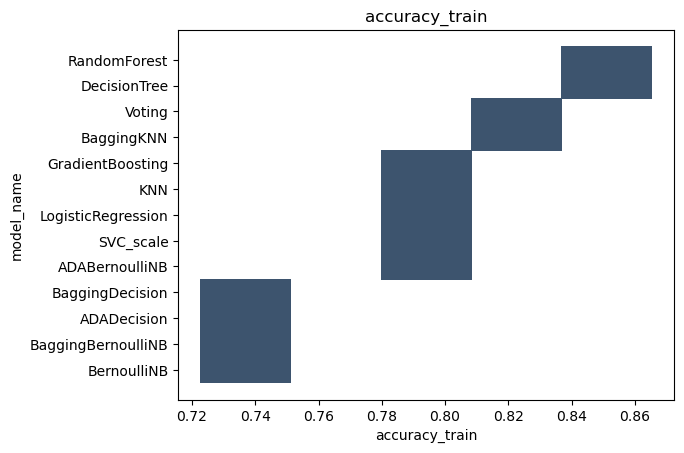

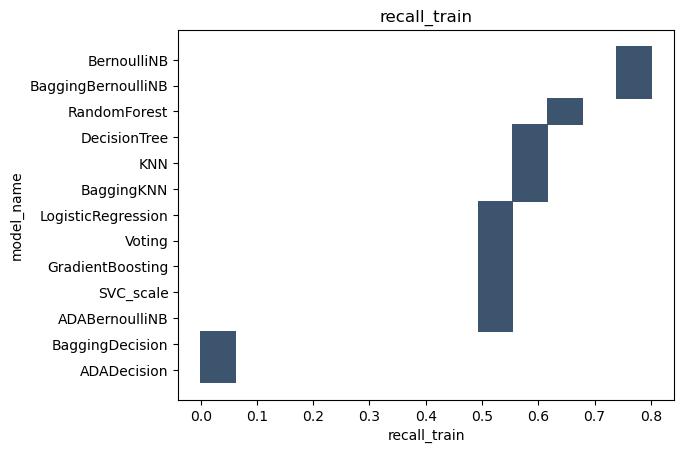

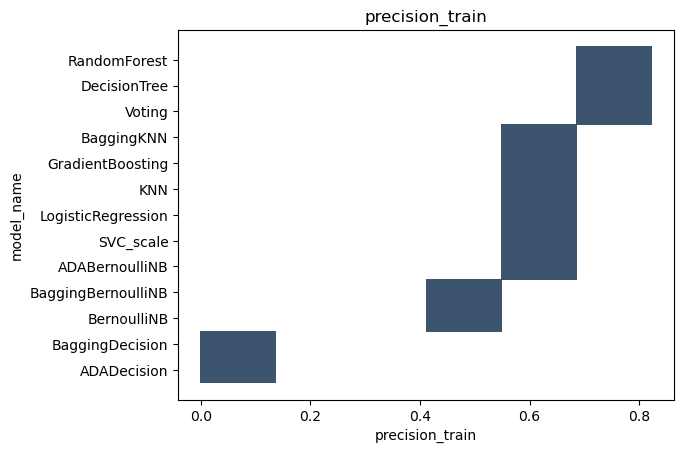

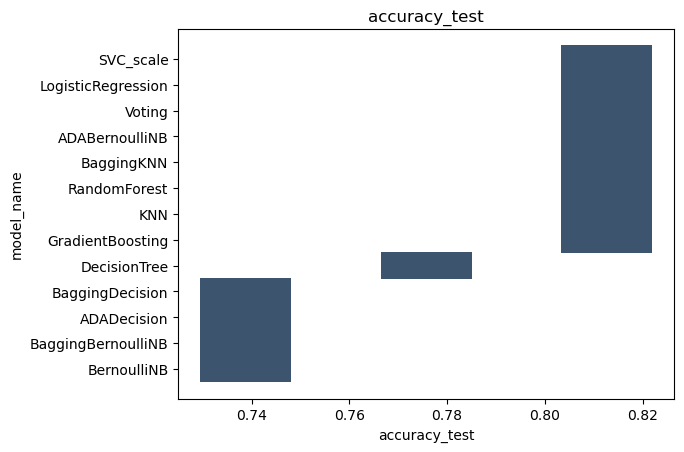

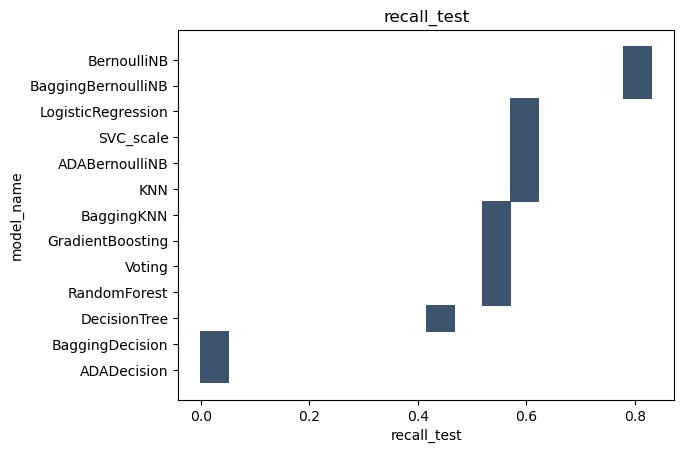

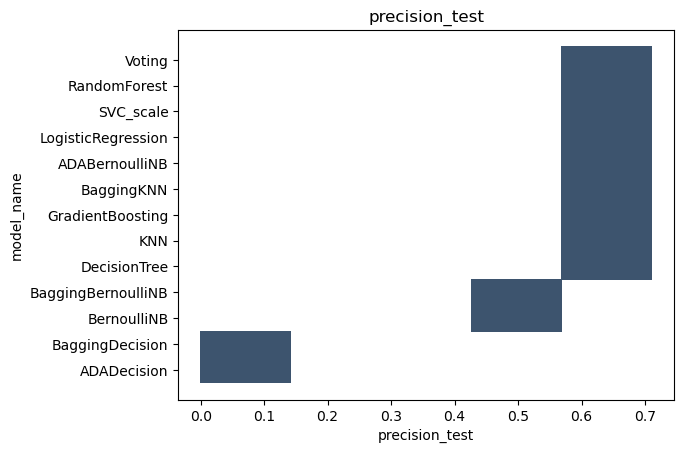

In [375]:
for col in sum_col:
    plt.title(col)
    sns.histplot(data=result.sort_values(by=col,ascending=False),y='model_name',x= col)
    plt.show()